In [1]:
import re
import pickle

import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
# trainset_path = '../../Datasets/public_news_set/multimodal_train_cleaned_sample.tsv'
# trainset_path = '../../Datasets/public_news_set/multimodal_valid_cleaned_sample.tsv'
trainset_path = '../../Datasets/public_news_set/multimodal_test_cleaned_sample.tsv'

cmt_path = '../../Datasets/public_news_set/all_comments.tsv'

In [3]:
train_df = pd.read_csv(trainset_path, sep='\t')
cmt_df = pd.read_csv(cmt_path, sep='\t')

/tmp/ipykernel_15225/736849751.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  cmt_df = pd.read_csv(cmt_path, sep='\t')


In [4]:
train_df.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,SheepTag,this cloud over boston ma,1.538092e+09,i.redd.it,True,9jhxro,https://preview.redd.it/9u7ixrejavo11.jpg?widt...,NaN,6.0,10,mildlyinteresting,"This cloud over Boston, Ma",0.78,1,0,0
1,hotsaucetran,fighter pilot with problems,1.410117e+09,NaN,True,ckbskv2,http://i.imgur.com/WYe5U7m.jpg,2fkydq,NaN,1,psbattle_artwork,Fighter Pilot with problems,NaN,0,2,4
2,OobeBanoobe,porysnake,1.557855e+09,NaN,True,enhpjku,https://i.imgur.com/Peda3sA.jpg,bojme8,NaN,2,psbattle_artwork,Porysnake,NaN,0,2,4
3,raygunedward,this photocopy of a employees must wash hands ...,1.535746e+09,i.redd.it,True,9bwxey,https://preview.redd.it/5brc4fmkjhj11.jpg?widt...,NaN,2.0,3,mildlyinteresting,"this photocopy of a ""employees must wash hands...",0.62,1,0,0
4,ReyGG,rfakehistoryporn users when they post memes,1.552236e+09,i.redd.it,True,azhg0p,https://preview.redd.it/54nryjyvkbl21.jpg?widt...,NaN,12.0,394,fakehistoryporn,r/fakehistoryporn users when they post memes (...,0.98,0,2,2


In [5]:
cmt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10697533 entries, 0 to 10697532
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Unnamed: 0     object 
 1   id             object 
 2   author         object 
 3   body           object 
 4   isTopLevel     object 
 5   parent_id      object 
 6   submission_id  object 
 7   ups            float64
dtypes: float64(1), object(7)
memory usage: 652.9+ MB


In [6]:
cmt_df.head()

,Unnamed: 0,id,author,body,isTopLevel,parent_id,submission_id,ups
0,0,f4deplg,Haus42,"Scroll, scroll, scroll. Pause. Scroll back u...",True,t3_dkdml1,dkdml1,162.0
1,1,f4d79bi,PotatoPrince84,A lot of the people who felt quite strongly ab...,True,t3_dkdml1,dkdml1,84.0
2,2,f4ddmlk,MadeToAchieveBalance,T H E S P H E R E S H A L L R I S E A ...,True,t3_dkdml1,dkdml1,34.0
3,3,f4dknfn,MrBigRed,All hail the cube of justice,True,t3_dkdml1,dkdml1,9.0
4,4,f4dgdur,burritosenior,That is glorious.,True,t3_dkdml1,dkdml1,4.0


In [7]:
combination = train_df.merge(cmt_df, left_on='id', right_on='submission_id', how='left')

In [8]:
combination.head()

,author_x,clean_title,created_utc,domain,hasImage,id_x,image_url,linked_submission_id,num_comments,score,...,3_way_label,6_way_label,Unnamed: 0,id_y,author_y,body,isTopLevel,parent_id,submission_id,ups
0,SheepTag,this cloud over boston ma,1.538092e+09,i.redd.it,True,9jhxro,https://preview.redd.it/9u7ixrejavo11.jpg?widt...,NaN,6.0,10,...,0,0,6468005,e6rl54f,Rustynails77777,So Bostonian.,True,t3_9jhxro,9jhxro,3.0
1,SheepTag,this cloud over boston ma,1.538092e+09,i.redd.it,True,9jhxro,https://preview.redd.it/9u7ixrejavo11.jpg?widt...,NaN,6.0,10,...,0,0,6468006,e6rm0ry,3ch0ing,Is it just me or are there more posts here abo...,True,t3_9jhxro,9jhxro,2.0
2,SheepTag,this cloud over boston ma,1.538092e+09,i.redd.it,True,9jhxro,https://preview.redd.it/9u7ixrejavo11.jpg?widt...,NaN,6.0,10,...,0,0,6468007,e6rms5b,Barrison267,I feel as though this would fit better on anot...,True,t3_9jhxro,9jhxro,2.0
3,SheepTag,this cloud over boston ma,1.538092e+09,i.redd.it,True,9jhxro,https://preview.redd.it/9u7ixrejavo11.jpg?widt...,NaN,6.0,10,...,0,0,6468008,e6rlais,SheepTag,You right...,False,t1_e6rl54f,9jhxro,1.0
4,SheepTag,this cloud over boston ma,1.538092e+09,i.redd.it,True,9jhxro,https://preview.redd.it/9u7ixrejavo11.jpg?widt...,NaN,6.0,10,...,0,0,6468009,e6roi1s,SheepTag,"Zoom in, the formations of the cloud close up ...",False,t1_e6rms5b,9jhxro,1.0


In [9]:
combination[combination.body.isna()!= True]['id_x']

0         9jhxro
1         9jhxro
2         9jhxro
3         9jhxro
4         9jhxro
           ...  
136673    99sl5a
136674    99sl5a
136675    99sl5a
136676    99sl5a
136677    99sl5a
Name: id_x, Length: 130057, dtype: object

In [10]:
len(combination)

136678

In [11]:
combination[combination['6_way_label'] != 4]['num_comments'] < 1

0         False
1         False
2         False
3         False
4         False
          ...  
136673    False
136674    False
136675    False
136676    False
136677    False
Name: num_comments, Length: 132557, dtype: bool

In [12]:
combination.iloc[combination['num_comments'].idxmax()]

author_x                                                     disasterbenz
clean_title             kellyanne conway suggests barack obama was spy...
created_utc                                                  1489405523.0
domain                                                  independent.co.uk
hasImage                                                             True
id_x                                                               5z4it6
image_url               https://external-preview.redd.it/oMAKK-jr3l1ju...
linked_submission_id                                                  NaN
num_comments                                                       5037.0
score                                                               48162
subreddit                                                     nottheonion
title                   Kellyanne Conway suggests Barack Obama was spy...
upvote_ratio                                                         0.72
2_way_label                           

In [13]:
clean_cmt = combination[combination['body'].isna() == False]

In [14]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    new_text = " ".join(new_text)
    new_text = re.sub(r'(@.*?)[\s]', ' ', new_text)
    new_text = re.sub(r'&amp;', '&', new_text)
    new_text = re.sub(r'\s+', ' ', new_text).strip()
    new_text = re.sub(r'[^\w\s]','',new_text)
    return new_text

In [15]:
clean_cmt['clean_body'] = clean_cmt['body'].apply(lambda x: preprocess(x))

/tmp/ipykernel_15225/2969585622.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_cmt['clean_body'] = clean_cmt['body'].apply(lambda x: preprocess(x))


In [16]:
clean_cmt.head()

,author_x,clean_title,created_utc,domain,hasImage,id_x,image_url,linked_submission_id,num_comments,score,...,6_way_label,Unnamed: 0,id_y,author_y,body,isTopLevel,parent_id,submission_id,ups,clean_body
0,SheepTag,this cloud over boston ma,1.538092e+09,i.redd.it,True,9jhxro,https://preview.redd.it/9u7ixrejavo11.jpg?widt...,NaN,6.0,10,...,0,6468005,e6rl54f,Rustynails77777,So Bostonian.,True,t3_9jhxro,9jhxro,3.0,So Bostonian
1,SheepTag,this cloud over boston ma,1.538092e+09,i.redd.it,True,9jhxro,https://preview.redd.it/9u7ixrejavo11.jpg?widt...,NaN,6.0,10,...,0,6468006,e6rm0ry,3ch0ing,Is it just me or are there more posts here abo...,True,t3_9jhxro,9jhxro,2.0,Is it just me or are there more posts here abo...
2,SheepTag,this cloud over boston ma,1.538092e+09,i.redd.it,True,9jhxro,https://preview.redd.it/9u7ixrejavo11.jpg?widt...,NaN,6.0,10,...,0,6468007,e6rms5b,Barrison267,I feel as though this would fit better on anot...,True,t3_9jhxro,9jhxro,2.0,I feel as though this would fit better on anot...
3,SheepTag,this cloud over boston ma,1.538092e+09,i.redd.it,True,9jhxro,https://preview.redd.it/9u7ixrejavo11.jpg?widt...,NaN,6.0,10,...,0,6468008,e6rlais,SheepTag,You right...,False,t1_e6rl54f,9jhxro,1.0,You right
4,SheepTag,this cloud over boston ma,1.538092e+09,i.redd.it,True,9jhxro,https://preview.redd.it/9u7ixrejavo11.jpg?widt...,NaN,6.0,10,...,0,6468009,e6roi1s,SheepTag,"Zoom in, the formations of the cloud close up ...",False,t1_e6rms5b,9jhxro,1.0,Zoom in the formations of the cloud close up a...


/tmp/ipykernel_15225/2742813764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_cmt['words per sentence'] = clean_cmt['clean_body'].str.split().apply(len)


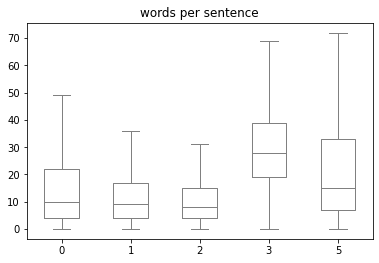

In [17]:
import matplotlib.pyplot as plt
clean_cmt['words per sentence'] = clean_cmt['clean_body'].str.split().apply(len)
clean_cmt.boxplot('words per sentence', by='6_way_label', grid=False, showfliers=False, color='gray')
plt.suptitle('')
plt.xlabel('')
plt.show()

## Sentiment Analysis on the comment data

In [18]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
import re
from scipy.special import softmax


MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained(MODEL)

text = "Good night 😊"
text = preprocess(text)
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
print(output, scores)
# Print labels and scores
ranking = np.argsort(scores)
ranking = ranking[::-1]
print(ranking)
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")


SequenceClassifierOutput(loss=None, logits=tensor([[-1.1317, -0.0453,  0.8233]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None) [0.09068741 0.26874894 0.64056367]
[2 1 0]
1) Positive 0.6406
2) Neutral 0.2687
3) Negative 0.0907


In [19]:
from torch.utils.data import Dataset

class CmtDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"

        self.tokenizer = AutoTokenizer.from_pretrained(MODEL)
        
        self.df = df['clean_body'].values
        self.clean_body = df['clean_body'].values
        self.ids = df['id_y'].values

    def __getitem__(self, idx):
        encoded_inputs = self.tokenizer(self.clean_body[idx], return_tensors='pt', truncation=True, padding="max_length", max_length=64)
        return self.ids[idx], encoded_inputs['input_ids'], encoded_inputs['attention_mask']

    def __len__(self):
        return len(self.df)
        

In [20]:
class SentimentExtractor(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"

        self.tokenizer = AutoTokenizer.from_pretrained(MODEL)
        self.config = AutoConfig.from_pretrained(MODEL)

        # PT
        self.model = AutoModelForSequenceClassification.from_pretrained(MODEL).to('cuda')

    def forward(self, input_ids, attention_mask):
        input_ids = input_ids.to('cuda')
        attention_mask = attention_mask.to('cuda')
        output = self.model(input_ids, attention_mask)
        scores = output.logits.detach().cpu().numpy()
        scores = softmax(scores, 1)
        # Print labels and scores
        ranking = np.argsort(scores)
        ranking = ranking[::-1]
        ranks = []
        for i in range(scores.shape[0]):
            rank = {}
            for j in range(scores.shape[1]):
                l = config.id2label[ranking[i][j]]
                s = scores[i][ranking[i][j]]
                # print(f"{i+1}) {l} {np.round(float(s), 4)}")
                rank[l] = s
            ranks.append(rank)
        return ranks

## Generate sentiment scores for the user comments

In [21]:
# generate sentiment scores
cmt_dataset = CmtDataset(clean_cmt)
cmt_loader = DataLoader(cmt_dataset, batch_size=32)

extractor = SentimentExtractor()
results = []
for term in tqdm(cmt_loader, total=len(cmt_loader)):
    ids = term[0]
    input_ids = term[1].squeeze(1)
    atn_masks = term[2].squeeze(1)
    outputs = extractor(input_ids, atn_masks)
    results.extend(list(zip(ids, outputs)))

100%|██████████| 4065/4065 [03:45<00:00, 18.03it/s]


In [22]:
# save sentiment scores to pickle
cmt_scores_path = 'cmt_scores_test'
with open(cmt_scores_path, 'wb') as fo:
    pickle.dump(results, fo)

In [23]:
with open(cmt_scores_path, 'rb') as fi:
    senti_scores = pickle.load(fi)

In [24]:
clean_cmt.head()

,author_x,clean_title,created_utc,domain,hasImage,id_x,image_url,linked_submission_id,num_comments,score,...,Unnamed: 0,id_y,author_y,body,isTopLevel,parent_id,submission_id,ups,clean_body,words per sentence
0,SheepTag,this cloud over boston ma,1.538092e+09,i.redd.it,True,9jhxro,https://preview.redd.it/9u7ixrejavo11.jpg?widt...,NaN,6.0,10,...,6468005,e6rl54f,Rustynails77777,So Bostonian.,True,t3_9jhxro,9jhxro,3.0,So Bostonian,2
1,SheepTag,this cloud over boston ma,1.538092e+09,i.redd.it,True,9jhxro,https://preview.redd.it/9u7ixrejavo11.jpg?widt...,NaN,6.0,10,...,6468006,e6rm0ry,3ch0ing,Is it just me or are there more posts here abo...,True,t3_9jhxro,9jhxro,2.0,Is it just me or are there more posts here abo...,15
2,SheepTag,this cloud over boston ma,1.538092e+09,i.redd.it,True,9jhxro,https://preview.redd.it/9u7ixrejavo11.jpg?widt...,NaN,6.0,10,...,6468007,e6rms5b,Barrison267,I feel as though this would fit better on anot...,True,t3_9jhxro,9jhxro,2.0,I feel as though this would fit better on anot...,16
3,SheepTag,this cloud over boston ma,1.538092e+09,i.redd.it,True,9jhxro,https://preview.redd.it/9u7ixrejavo11.jpg?widt...,NaN,6.0,10,...,6468008,e6rlais,SheepTag,You right...,False,t1_e6rl54f,9jhxro,1.0,You right,2
4,SheepTag,this cloud over boston ma,1.538092e+09,i.redd.it,True,9jhxro,https://preview.redd.it/9u7ixrejavo11.jpg?widt...,NaN,6.0,10,...,6468009,e6roi1s,SheepTag,"Zoom in, the formations of the cloud close up ...",False,t1_e6rms5b,9jhxro,1.0,Zoom in the formations of the cloud close up a...,16


In [25]:
sentiment_scores = pd.DataFrame(senti_scores, columns=['id', 'senti_scores'])

In [26]:
sentiment_scores.head()

,id,senti_scores
0,e6rl54f,"{'Positive': 0.15308759, 'Negative': 0.3536685..."
1,e6rm0ry,"{'Positive': 0.049524885, 'Neutral': 0.4293578..."
2,e6rms5b,"{'Positive': 0.48128498, 'Negative': 0.1644641..."
3,e6rlais,"{'Positive': 0.23331812, 'Negative': 0.3395265..."
4,e6roi1s,"{'Positive': 0.54561245, 'Neutral': 0.2888298,..."


In [27]:
new_clean_cmt = clean_cmt.merge(sentiment_scores, left_on='id_y', right_on='id')

In [28]:
new_clean_cmt.head()

,author_x,clean_title,created_utc,domain,hasImage,id_x,image_url,linked_submission_id,num_comments,score,...,author_y,body,isTopLevel,parent_id,submission_id,ups,clean_body,words per sentence,id,senti_scores
0,SheepTag,this cloud over boston ma,1.538092e+09,i.redd.it,True,9jhxro,https://preview.redd.it/9u7ixrejavo11.jpg?widt...,NaN,6.0,10,...,Rustynails77777,So Bostonian.,True,t3_9jhxro,9jhxro,3.0,So Bostonian,2,e6rl54f,"{'Positive': 0.15308759, 'Negative': 0.3536685..."
1,SheepTag,this cloud over boston ma,1.538092e+09,i.redd.it,True,9jhxro,https://preview.redd.it/9u7ixrejavo11.jpg?widt...,NaN,6.0,10,...,3ch0ing,Is it just me or are there more posts here abo...,True,t3_9jhxro,9jhxro,2.0,Is it just me or are there more posts here abo...,15,e6rm0ry,"{'Positive': 0.049524885, 'Neutral': 0.4293578..."
2,SheepTag,this cloud over boston ma,1.538092e+09,i.redd.it,True,9jhxro,https://preview.redd.it/9u7ixrejavo11.jpg?widt...,NaN,6.0,10,...,Barrison267,I feel as though this would fit better on anot...,True,t3_9jhxro,9jhxro,2.0,I feel as though this would fit better on anot...,16,e6rms5b,"{'Positive': 0.48128498, 'Negative': 0.1644641..."
3,SheepTag,this cloud over boston ma,1.538092e+09,i.redd.it,True,9jhxro,https://preview.redd.it/9u7ixrejavo11.jpg?widt...,NaN,6.0,10,...,SheepTag,You right...,False,t1_e6rl54f,9jhxro,1.0,You right,2,e6rlais,"{'Positive': 0.23331812, 'Negative': 0.3395265..."
4,SheepTag,this cloud over boston ma,1.538092e+09,i.redd.it,True,9jhxro,https://preview.redd.it/9u7ixrejavo11.jpg?widt...,NaN,6.0,10,...,SheepTag,"Zoom in, the formations of the cloud close up ...",False,t1_e6rms5b,9jhxro,1.0,Zoom in the formations of the cloud close up a...,16,e6roi1s,"{'Positive': 0.54561245, 'Neutral': 0.2888298,..."


In [29]:
combination[combination['body'].isna() ==True]['6_way_label'].value_counts()

4    4121
2    1140
0     906
1     378
5      69
3       7
Name: 6_way_label, dtype: int64

In [30]:
new_clean_cmt['6_way_label'].value_counts()

0    98283
2    13141
5     9356
3     6496
1     2781
Name: 6_way_label, dtype: int64

In [31]:
# count the avg sentiment scores for different categories

sscores = new_clean_cmt

In [32]:
sscores['pos'] = new_clean_cmt['senti_scores'].apply(lambda x: x['Positive'])
sscores['neu'] = new_clean_cmt['senti_scores'].apply(lambda x: x['Neutral'])
sscores['neg'] = new_clean_cmt['senti_scores'].apply(lambda x: x['Negative'])


In [33]:
sscores[['pos', 'neu', 'neg']]

,pos,neu,neg
0,0.153088,0.493244,0.353669
1,0.049525,0.429358,0.521117
2,0.481285,0.354251,0.164464
3,0.233318,0.427155,0.339527
4,0.545612,0.288830,0.165558
...,...,...,...
130052,0.261491,0.548998,0.189510
130053,0.357523,0.427931,0.214546
130054,0.261949,0.439652,0.298399
130055,0.182786,0.614774,0.202440


In [34]:
avg_scores_df = sscores.groupby('6_way_label')[['pos', 'neu', 'neg']].mean()
avg_scores_df

,pos,neu,neg
6_way_label,,,
0,0.206174,0.361127,0.432699
1,0.279261,0.362392,0.358348
2,0.207952,0.361868,0.430181
3,0.179401,0.312694,0.507905
5,0.168485,0.322456,0.509059


In [35]:
avg_scores = dict()
avg_scores[0] = avg_scores_df.iloc[0].tolist()
avg_scores[1] = avg_scores_df.iloc[1].tolist()
avg_scores[2] = avg_scores_df.iloc[2].tolist()
avg_scores[3] = avg_scores_df.iloc[3].tolist()
avg_scores[5] = avg_scores_df.iloc[4].tolist()

In [36]:
avg_scores

{0: [0.2061741203069687, 0.3611266016960144, 0.4326992630958557],
 1: [0.2792605459690094, 0.36239171028137207, 0.35834774374961853],
 2: [0.2079516351222992, 0.361867755651474, 0.4301806092262268],
 3: [0.17940054833889008, 0.3126944303512573, 0.5079050064086914],
 5: [0.16848504543304443, 0.3224557340145111, 0.5090591907501221]}

In [37]:
new_combination = combination.merge(new_clean_cmt[['id', 'pos', 'neu', 'neg']], left_on='id_y', right_on='id', how='left')

In [38]:
def sscores_fillna(term):
   
    if pd.isnull(term['pos']):
        if term['6_way_label'] !=4:
            avg_score = avg_scores[term['6_way_label']]
            term.pos = avg_score[0]
            term.neu = avg_score[1]
            term.neg = avg_score[2]
            return term
        else:
            term.pos = 0.25
            term.neu = 0.5
            term.neg = 0.25
            return term
    return term

In [39]:
nnew_combination = new_combination.apply(lambda x: sscores_fillna(x) , axis=1)

In [40]:
nnew_combination[['id_x', '6_way_label', 'pos', 'neu', 'neg']]

,id_x,6_way_label,pos,neu,neg
0,9jhxro,0,0.153088,0.493244,0.353669
1,9jhxro,0,0.049525,0.429358,0.521117
2,9jhxro,0,0.481285,0.354251,0.164464
3,9jhxro,0,0.233318,0.427155,0.339527
4,9jhxro,0,0.545612,0.288830,0.165558
...,...,...,...,...,...
136673,99sl5a,2,0.261491,0.548998,0.189510
136674,99sl5a,2,0.357523,0.427931,0.214546
136675,99sl5a,2,0.261949,0.439652,0.298399
136676,99sl5a,2,0.182786,0.614774,0.202440


In [41]:
final_sentscores = nnew_combination.groupby('id_x')[['pos', 'neu', 'neg']].mean()
final_sentscores

,pos,neu,neg
id_x,,,
100y14,0.206174,0.361127,0.432699
106gjx,0.311232,0.428610,0.260158
107g4r,0.340427,0.367604,0.291970
107qmh,0.314970,0.423883,0.261147
10bl9g,0.207952,0.361868,0.430181
...,...,...,...
zs330,0.206174,0.361127,0.432699
zuzve,0.246636,0.481036,0.272328
zvvbh,0.254900,0.544452,0.200648


In [42]:
train_df

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,SheepTag,this cloud over boston ma,1.538092e+09,i.redd.it,True,9jhxro,https://preview.redd.it/9u7ixrejavo11.jpg?widt...,NaN,6.0,10,mildlyinteresting,"This cloud over Boston, Ma",0.78,1,0,0
1,hotsaucetran,fighter pilot with problems,1.410117e+09,NaN,True,ckbskv2,http://i.imgur.com/WYe5U7m.jpg,2fkydq,NaN,1,psbattle_artwork,Fighter Pilot with problems,NaN,0,2,4
2,OobeBanoobe,porysnake,1.557855e+09,NaN,True,enhpjku,https://i.imgur.com/Peda3sA.jpg,bojme8,NaN,2,psbattle_artwork,Porysnake,NaN,0,2,4
3,raygunedward,this photocopy of a employees must wash hands ...,1.535746e+09,i.redd.it,True,9bwxey,https://preview.redd.it/5brc4fmkjhj11.jpg?widt...,NaN,2.0,3,mildlyinteresting,"this photocopy of a ""employees must wash hands...",0.62,1,0,0
4,ReyGG,rfakehistoryporn users when they post memes,1.552236e+09,i.redd.it,True,azhg0p,https://preview.redd.it/54nryjyvkbl21.jpg?widt...,NaN,12.0,394,fakehistoryporn,r/fakehistoryporn users when they post memes (...,0.98,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13639,NaN,secret service skater,1.368294e+09,NaN,True,c9wu0xm,http://i.imgur.com/XMptYdQ.jpg,1e3ssk,NaN,4,psbattle_artwork,Secret Service Skater,NaN,0,2,4
13640,Innova,pants used as planting pots,1.514988e+09,i.imgur.com,True,7nuslc,https://external-preview.redd.it/qHYDlJ1-_dNO6...,NaN,814.0,26925,photoshopbattles,PsBattle: Pants used as planting pots,0.88,1,0,0
13641,NaN,the babadook is getting a new limited edition ...,1.559683e+09,birthmoviesdeath.com,True,bwu952,https://external-preview.redd.it/0aeDxm2NXEPc5...,NaN,29.0,45,nottheonion,The Babadook Is Getting A New Limited Edition ...,0.81,1,0,0
13642,Rachael1188,picture i took at a plant nursery in alabama,1.567091e+09,i.redd.it,True,cx25nb,https://preview.redd.it/xmn61958lej31.jpg?widt...,NaN,0.0,19,mildlyinteresting,Picture I took at a plant nursery in Alabama.,0.96,1,0,0


In [43]:
train_with_sentiment = train_df.merge(final_sentscores, left_on='id', right_on='id_x', how='left')
train_with_sentiment.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label,pos,neu,neg
0,SheepTag,this cloud over boston ma,1.538092e+09,i.redd.it,True,9jhxro,https://preview.redd.it/9u7ixrejavo11.jpg?widt...,NaN,6.0,10,mildlyinteresting,"This cloud over Boston, Ma",0.78,1,0,0,0.261303,0.399116,0.339581
1,hotsaucetran,fighter pilot with problems,1.410117e+09,NaN,True,ckbskv2,http://i.imgur.com/WYe5U7m.jpg,2fkydq,NaN,1,psbattle_artwork,Fighter Pilot with problems,NaN,0,2,4,0.250000,0.500000,0.250000
2,OobeBanoobe,porysnake,1.557855e+09,NaN,True,enhpjku,https://i.imgur.com/Peda3sA.jpg,bojme8,NaN,2,psbattle_artwork,Porysnake,NaN,0,2,4,0.250000,0.500000,0.250000
3,raygunedward,this photocopy of a employees must wash hands ...,1.535746e+09,i.redd.it,True,9bwxey,https://preview.redd.it/5brc4fmkjhj11.jpg?widt...,NaN,2.0,3,mildlyinteresting,"this photocopy of a ""employees must wash hands...",0.62,1,0,0,0.070087,0.493951,0.435962
4,ReyGG,rfakehistoryporn users when they post memes,1.552236e+09,i.redd.it,True,azhg0p,https://preview.redd.it/54nryjyvkbl21.jpg?widt...,NaN,12.0,394,fakehistoryporn,r/fakehistoryporn users when they post memes (...,0.98,0,2,2,0.097361,0.439025,0.463614


In [44]:
train_with_sentiment.to_csv('new_test_with_sentiment.tsv', sep='\t', index=False)